# Regression for fitting Fabre data to logistic function

Model to fit:
\begin{equation}
y_i = \frac{1}{1+(1-n_0)e^{-\gamma (t_i-t_0)}}
\end{equation}
Unknown parameters: ${n_0, t_0, \gamma}$

Which statistical fitting method should we use?
- Linear regression: Cannot be used bc logistic model cannot be written as a linear combination of its parameters
- Least squares: Potentially? Does not actually require linearity, though must check how to apply to more general functions? Also, note that variance of error depends on explainable parameters.
- What if instead, we fit the logistic model, after applying sampling?
- Binomial regression?



## Weighted least squares:

Minimise weighted squared residuals:
\begin{equation}
r_i(\beta) = y_i - f(x_i,\beta)
\end{equation}

Minimise
\begin{equation}
S = \sum_i W_{ii} r_i^2
\end{equation}
with 
\begin{equation}
W_{ii} = \frac{1}{\sigma_i^2}
\end{equation}
i.e. the weight of a measurement is the reciprocal its variance.

## Maximum Likelihood Estimation

Denote $f(t, \beta)$ the logistic growth function bounded between 0 and 0.5, taken at time $t$ with parameter set $\beta = \lbrace t_0, n_0, \gamma \rbrace$. The probability of measuring $j$ counts of a variant under $f(t, \beta)$ with a coverage $K$ is given by the binomial distribution:
\begin{equation}
P(j) = {K \choose j} f(t,\beta)^{j} \left[ 1-f(t,\beta) \right]^{(K-j)}
\end{equation}

Denote $V = \lbrace v_{i} \rbrace$ the set of measured variant calls obtained at times $\lbrace t_i \rbrace$. The probability of obtaining the sample set $V$ under a model $\beta$ is thus given by
\begin{equation}
\mathcal{L}(\beta) = \prod_{i} P(v_i)
\end{equation}
This is the likelihood of the measurement given the model. Assuming the model $f(t, \beta)$, in order to obtain the best fitting set of parameters $\beta$ we simply maximize $\mathcal{L}(\beta)$.

In [4]:
using CSV, DataFrames, Statistics, StatsBase
include("../../src/dataStructuring.jl")
using .DataStructuring
include("../../src/competitiveSelection.jl")
using .CompetitiveSelection

Fit data to logistic curves.

In [2]:
df = DataFrame(CSV.File("../../Data/ALLvariants_exclSynonymous_Xadj.txt"))
Nf = 2E5
dfVid = DataStructuring.analyseVariants(df, Nf);

Progress:   4%|██                                       |  ETA: 0:02:38┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [3]
└ @ Optim C:\Users\monper02\.julia\packages\Optim\tP8PJ\src\multivariate\solvers\constrained\fminbox.jl:314
┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [3]
└ @ Optim C:\Users\monper02\.julia\packages\Optim\tP8PJ\src\multivariate\solvers\constrained\fminbox.jl:314
Progress:  39%|█████████████████                        |  ETA: 0:00:33┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [3]
└ @ Optim C:\Users\monper02\.julia\packages\Optim\tP8PJ\src\multivariate\solvers\constrained\fminbox.jl:314
┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [3]
└ @ Optim 

Make simulations, sample, and fit to logistic curves.

In [36]:
paramsPop = Dict(
    :N => Nf,
    :α => 1,
    # :s => 0.12,
    :s => 0.05,
    :σ => 0.2,
    :T => 105,
    # :μ => 0.14,
    :μ => 0.24,
    :sType => "gamma",
    # :sType => "free",
    :q => 0.3,    #double hit probability: 0 = no double hits; 1 = double hits succeed with probability 1.
)
runs = 5000;

In [37]:
@time solEns = CompetitiveSelection.evolvePopSim(paramsPop, runs=runs)
@time fit_tλ_cid = CompetitiveSelection.fitSamplesGrowth(solEns, paramsPop, tMeasure=(50,90), timeLimit=0.4)

  4.242016 seconds (2.55 M allocations: 338.246 MiB)


┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [3]
└ @ Optim C:\Users\monper02\.julia\packages\Optim\tP8PJ\src\multivariate\solvers\constrained\fminbox.jl:314
┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [3]
└ @ Optim C:\Users\monper02\.julia\packages\Optim\tP8PJ\src\multivariate\solvers\constrained\fminbox.jl:314
┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [3]
└ @ Optim C:\Users\monper02\.julia\packages\Optim\tP8PJ\src\multivariate\solvers\constrained\fminbox.jl:314
┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [3]
└ @ Optim C:\Users\monper02\.julia\packages\Optim\tP8PJ\src\multivariate\solvers\constrained\fminbox.jl:314
┌ Warning: Initial position cannot be on the

  3.574952 seconds (5.30 M allocations: 370.984 MiB, 18.20% gc time)


2×1651 ElasticArrays.ElasticMatrix{Float64, Vector{Float64}}:
 51.8398  87.1493     67.3382  70.4256  …  85.5369  66.8779  89.7488  84.2177
  5.0      0.0528216   5.0      5.0         5.0      5.0      5.0      5.0

## Plotting

In [7]:
using CairoMakie
rscale=0.8
myTheme = Theme(
    resolution=(rscale*700,rscale*600),
    fontsize=17,
)
set_theme!(myTheme)

Growth curves for individual variants:

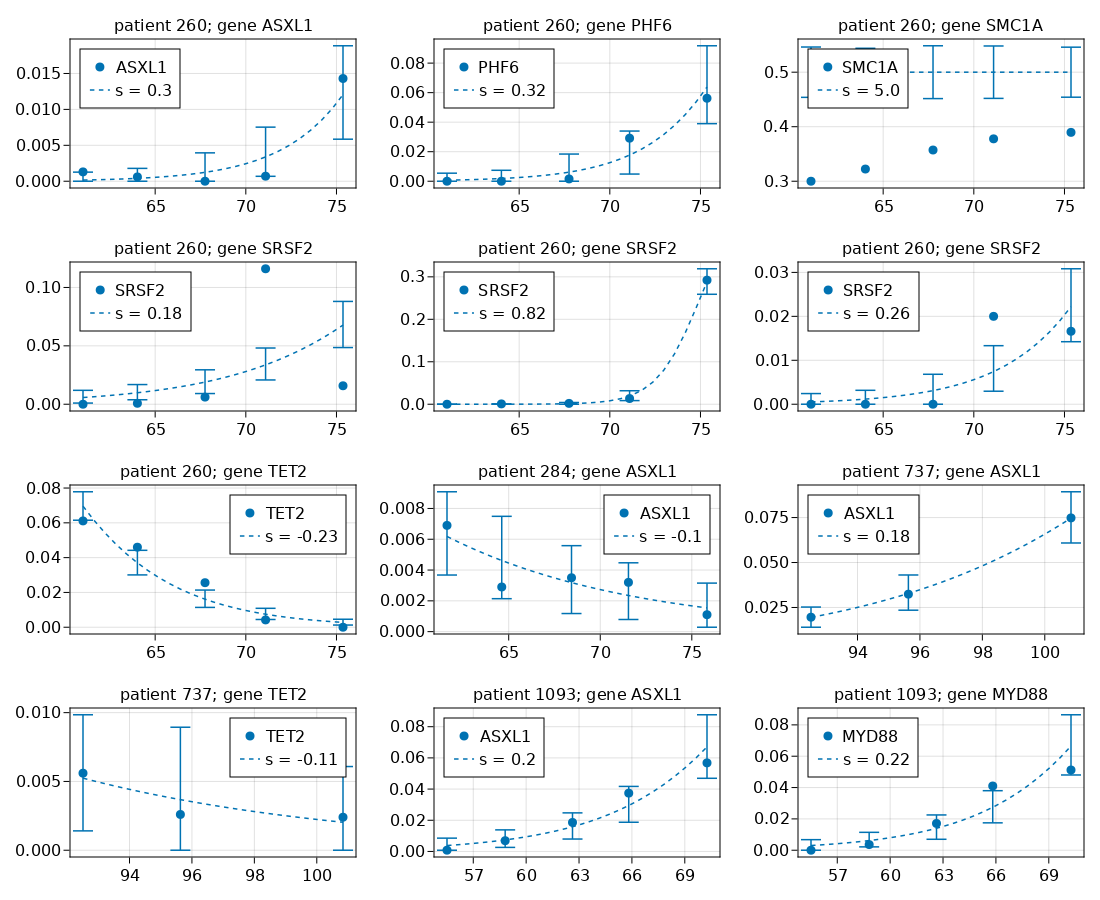

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x00000000de6457b0, 2200.0, 1800.0)


In [10]:
fsize=16
fig1 = Figure(resolution=(1100,900), fontsize=fsize)
nRows = 4
nCols = 3
for (i,dfVCur) in enumerate(eachrow(dfVid[1:12,:]))
    row = i / nCols |> ceil |> Int
    col = (i-1) % nCols + 1
    ax = Axis(
        fig1[row,col],
        title="patient "*string(dfVCur[:pid])*"; gene "*dfVCur[:gene],
    )
    scatter!(dfVCur[:_t], dfVCur[:vaf_t],
        linestyle=:solid,
        label=dfVCur[:gene],
    )
    lines!(dfVCur[:_tt], dfVCur[:vafTh_tt],
        linestyle=:dash,
        label="s = "*string(round(dfVCur[:λ],digits=2)),
    )
    rangebars!(
        dfVCur[:_t], dfVCur[:vafThQl_t], dfVCur[:vafThQu_t],
        whiskerwidth = 20,
        cycle = [:color],
    )
    legendpos = ( dfVCur[:ρ]>0 ? :lt : :rt )
    axislegend(position=legendpos)
end
display(fig1)
saveFolder = "../../x`Figures/Presentations/"
save(saveFolder*"individualTrajectories_LogitFitted.png", fig1, px_per_unit = 2)

All fitted growth rates.

Note that the fitted parameter is not exactly the fitness value $s$, but as it is multiplied by the wild type fitness rate:
\begin{equation}
r = \alpha s
\end{equation}
However, since the wildtype growth rate is likely close to 1, we can interpret this as something close to $s$.

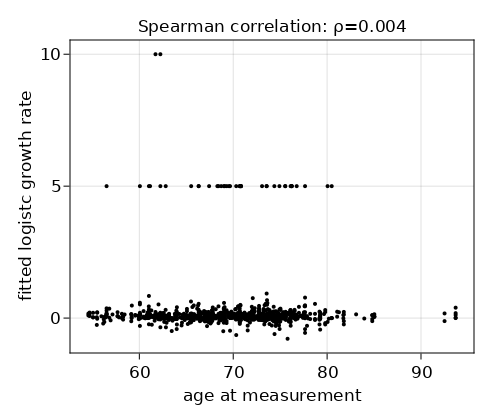

In [48]:
fig2 = Figure(
    resolution=(0.7*700,0.7*600),
    fontsize=17,
)
ρS = corspearman([dfVidCur[:_t][1] for dfVidCur in eachrow(dfVid)], dfVid[!, :λ])
Axis(
    fig2[1,1],
    xlabel="age at measurement",
    ylabel="fitted logistc growth rate",
    title="Spearman correlation: ρ="*string(round(ρS,digits=3))
)
scatter!(
    [dfVidCur[:_t][1] for dfVidCur in eachrow(dfVid)],
    dfVid[!, :λ],
    color=:black,
    markersize=4,
)
display(fig2)

The MLE fails to fit numerous variants (those that bunch at $r=5$ and $r=10$).

Removing these failed fits (gr > 1) we get:

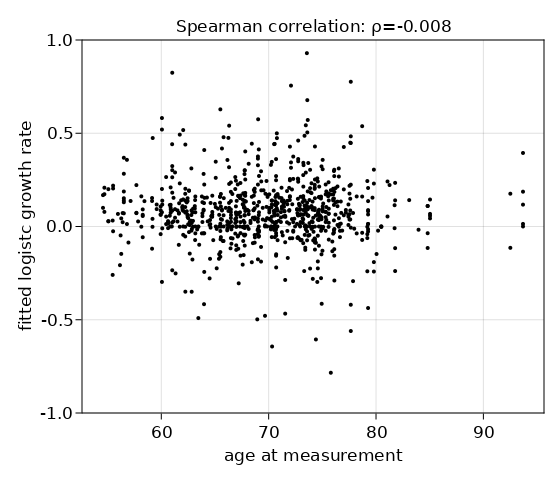

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x00000000e0237830, 1120.0, 960.0)


In [14]:
rscale = 0.8
fig2 = Figure(
    resolution=(rscale*700,rscale*600),
    fontsize=17,
)
_timeMask = [dfVCur[:_t][1]<90 for dfVCur in eachrow(dfVid)]
_λMask = [dfVCur[:λ]<2 for dfVCur in eachrow(dfVid)]
ρS = corspearman([dfVidCur[:_t][1] for dfVidCur in eachrow(dfVid[_λMask,:])], dfVid[_λMask, :λ])
Axis(
    fig2[1,1],
    xlabel="age at measurement",
    ylabel="fitted logistc growth rate",
    title="Spearman correlation: ρ="*string(round(ρS,digits=3))
)
scatter!(
    [dfVidCur[:_t][1] for dfVidCur in eachrow(dfVid)],
    dfVid[!, :λ],
    color=:black,
    markersize=4,
)
ylims!(-1,1)
display(fig2)
saveFolder = "../../Figures/Presentations/"
save(saveFolder*"fitnessFits_logit.png", fig2, px_per_unit = 2)

Fitness Distribution:

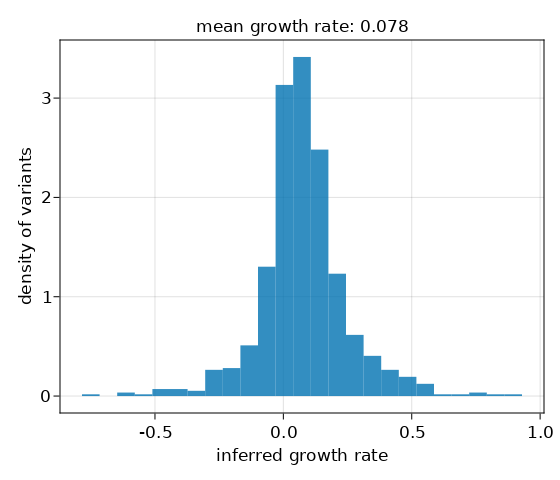

In [16]:
fig2b = Figure(
    resolution=(rscale*700,rscale*600),
    fontsize=17,
)
Axis(
    fig2b[1,1],
    xlabel="inferred growth rate",
    ylabel="density of variants",
    title="mean growth rate: "*string( round(mean(dfVid[_λMask,:λ]), digits=3) )
)
hist!(dfVid[_λMask, :λ], normalization=:pdf, bins=25)
display(fig2b)

Mean fitness over time:

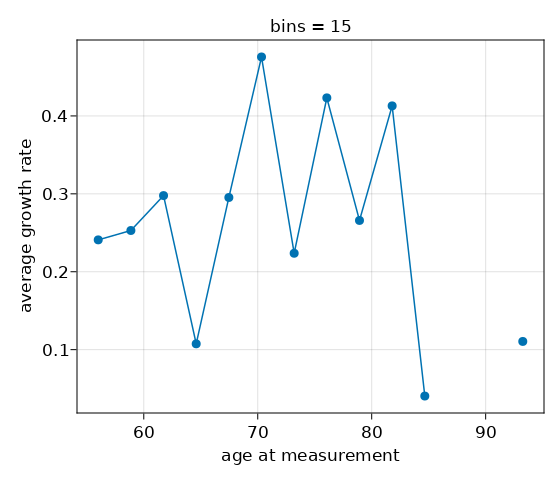

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x00000000ee1074e0, 1120.0, 960.0)


In [22]:
bins = 15
_tBin, λAv_tBin = DataStructuring.meanVarFitParamTime([dfVidCur[:_t][1] for dfVidCur in eachrow(dfVid)], dfVid[!, :λ]; bins)
fig3a = Figure()
Axis(
    fig3a[1,1],
    xlabel="age at measurement",
    ylabel="average growth rate",
    title="bins = "*string(bins)
)
scatterlines!(_tBin, λAv_tBin)
display(fig3a)
saveFolder = "../../Figures/Presentations/"
save(saveFolder*"binnedAvFitnessLogit.png", fig3a, px_per_unit = 2)

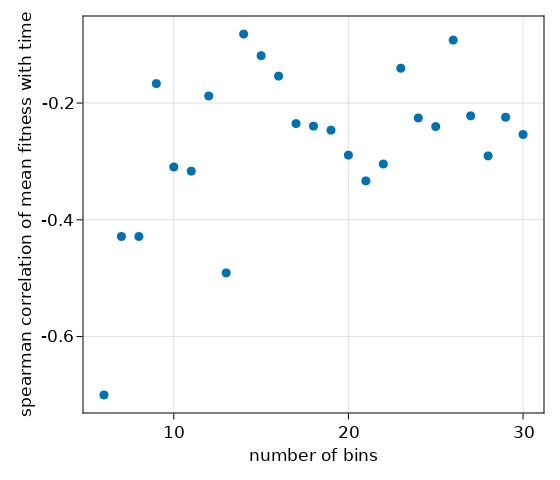

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x00000000ee10bfe0, 1120.0, 960.0)


In [23]:
mean(dfVid[_λMask,:λ])
nBins = 6:30
corS_nBins = Vector{Float64}(undef, length(nBins))
for (i,bins) in enumerate(nBins)
    _tBin, λAv_tBin = DataStructuring.meanVarFitParamTime([dfVidCur[:_t][1] for dfVidCur in eachrow(dfVid)], dfVid[!, :λ]; bins)
    corS_nBins[i] = corspearman(_tBin[.!isnan.(λAv_tBin)], λAv_tBin[.!isnan.(λAv_tBin)])
end
fig3 = Figure()
Axis(
    fig3[1,1],
    xlabel="number of bins",
    ylabel="spearman correlation of mean fitness with time"
)
scatter!(nBins, corS_nBins)
display(fig3)
saveFolder = "../../Figures/Presentations/"
save(saveFolder*"spearmanCorrelationPerBinNumber.png", fig3, px_per_unit = 2)

## Simulations

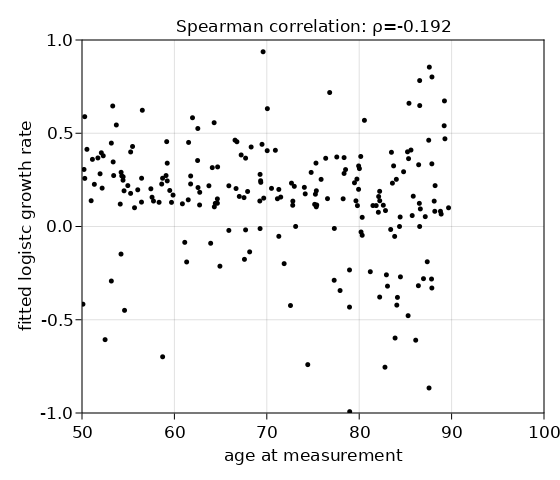

In [38]:
fig4 = Figure()
_λmask = fit_tλ_cid[2,:] .<= 1
ρSpSim = corspearman(fit_tλ_cid[1,_λmask], fit_tλ_cid[2,_λmask])
Axis(
    fig4[1,1],
    xlabel="age at measurement",
    ylabel="fitted logistc growth rate",
    title="Spearman correlation: ρ="*string(round(ρSpSim,digits=3))
)
scatter!(
    fit_tλ_cid[1,_λmask], fit_tλ_cid[2,_λmask],
    color=:black,
    markersize=5,
)
xlims!(50,100)
ylims!(-1,1)
display(fig4)

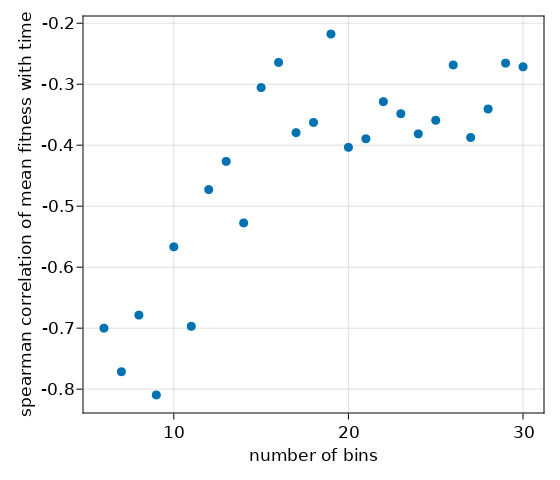

In [39]:
nBins = 6:30
corSpSims_nBins = Vector{Float64}(undef, length(nBins))
for (i,bins) in enumerate(nBins)
    @views _tBin, λAv_tBin = DataStructuring.meanVarFitParamTime(fit_tλ_cid[1,_λmask],fit_tλ_cid[2,_λmask]; bins)
    corSpSims_nBins[i] = corspearman(_tBin, λAv_tBin)
end
fig3 = Figure()
Axis(
    fig3[1,1],
    xlabel="number of bins",
    ylabel="spearman correlation of mean fitness with time"
)
scatter!(nBins, corSpSims_nBins)
display(fig3)